In [1]:
import sys
sys.path.append('../')
sys.path.append('old/')

import matplotlib.pyplot as plt

import FiniteDifferences_ShortleyWeller_SquareGrid as PIC_FDSW
import FiniteDifferences_Staircase_SquareGrid as PIC_FD
import FFT_OpenBoundary_SquareGrid as PIC_FFT
import geom_impact_ellip as ell
from scipy import rand
import numpy as np

In [2]:
from pypic import PyPIC_Fortran_M2P_P2M, PyPIC
from meshing import RectMesh2D
from poisson_solver import FD_solver as FD
from poisson_solver import FFT_solver as FFT
from poisson_solver.FD_solver import laplacian_2D_5stencil

pycuda not found. no gpu capabilities will be available
pycuda not found. no gpu capabilities will be available
GPU libraries (pycuda, cusolver_RF) not found. GPU functionality not available.


In [3]:
R_cham = 1e-1
R_charge = 4e-2
N_part_gen = 100000
Dh = 1e-3

from scipy.constants import e, epsilon_0

qe = e
eps0 = epsilon_0

chamber = ell.ellip_cham_geom_object(x_aper = R_cham, y_aper = R_cham)


poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid(chamb=chamber, Dh=Dh, ext_boundary=True) #use ext=True bc. FFT also requires this
poissonsolver_FFT = FFT.FFT_OpenBoundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)

mesh = RectMesh2D(poissonsolver.bias_x,
                  poissonsolver.bias_y,
                  Dh, Dh,
                  poissonsolver.Nxg,
                  poissonsolver.Nyg)

print(mesh.nx, mesh.ny)



new_pp = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver)#, gradient=poissonsolver.gradient)
new_pp_FFT = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver_FFT)


picFD = PIC_FD.FiniteDifferences_Staircase_SquareGrid(chamb = chamber, Dh = Dh)
picFDSW = PIC_FDSW.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh, fftlib='pyfftw')

Mat. assembly 0%
Using scipy superlu solver...
Done PIC init.
Failed to import pyfftw
Got exception:  No module named pyfftw
Using numpy fft
(211, 207)
Start PIC init.:
Finite Differences, Square Grid
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Using scipy superlu solver...
Done PIC init.
Start PIC init.:
Finite Differences, Shortley-Weller, Square Grid
Using Shortley-Weller boundary approx.
PyPIC Version 1.01
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Ma

In [4]:
def test_new_solver(new_solver, xx, yy, charge=e, x_probe=None, y_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    mesh_charges = new_solver.particles_to_mesh(xx, yy, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(mesh_charges)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    for i, field in enumerate(mesh_e_fields):
        mesh_e_fields[i] = field.flatten()
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    return rho, phi, efx, efy, Ex, Ey


In [5]:
# generate particles
x_part = R_charge*(2.*rand(N_part_gen)-1.)
y_part = R_charge*(2.*rand(N_part_gen)-1.)
mask_keep  = x_part**2+y_part**2<R_charge**2
x_part = x_part[mask_keep]
y_part = y_part[mask_keep]

nel_part = 0*x_part+1.

#pic scatter
picFD.scatter(x_part, y_part, nel_part, charge=e)
picFDSW.scatter(x_part, y_part, nel_part, charge=e)
picFFT.scatter(x_part, y_part, nel_part, charge=e)


#pic scatter
picFD.solve()
picFDSW.solve()
picFFT.solve()


    
x_probes = np.linspace(0,R_cham,1000)
y_probes = 0. * x_probes

    

rho_FFT, phi_FFT, efx_FFT, efy_FFT, Ex_FFT, Ey_FFT = test_new_solver(new_pp_FFT, xx=x_part, yy=y_part,
                                                                     charge=e,
                                                                     x_probe=x_probes, y_probe=y_probes)

rho, phi, efx, efy, Ex, Ey = test_new_solver(new_pp, xx=x_part, yy=y_part,
                                             charge=e,
                                             x_probe=x_probes, y_probe=y_probes)

#pic gather
Ex_FD, Ey_FD = picFD.gather(x_probes, y_probes)
Ex_FDSW, Ey_FDSW = picFDSW.gather(x_probes, y_probes)
Ex_FFT, Ey_FFT = picFFT.gather(x_probes, y_probes)


E_r_th = map(lambda x: np.sum(x_part**2+y_part**2<x**2)*qe/eps0/(2*np.pi*x), x_probes)

/home/stefan/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in double_scalars


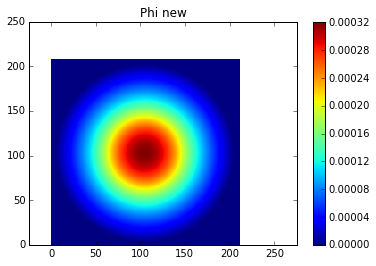

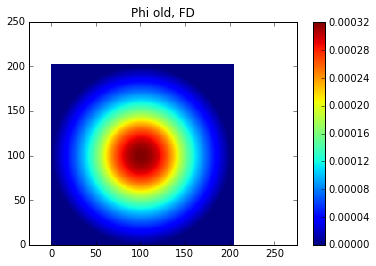

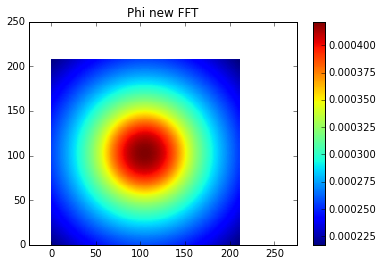

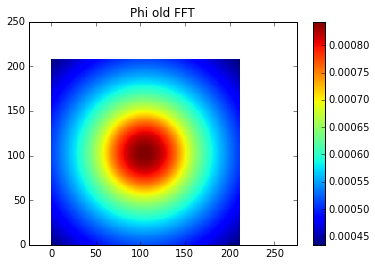

In [6]:
%matplotlib inline
plt.figure()
plt.pcolor(phi.reshape(mesh.ny, mesh.nx))
plt.colorbar()
plt.axis('equal')
plt.title('Phi new')
plt.show()



plt.figure()
plt.pcolor(picFDSW.phi.T[3:-2,4:-3])
plt.colorbar()
plt.title('Phi old, FD')
plt.axis('equal')
plt.show()

plt.figure()
plt.pcolor(phi_FFT.reshape(mesh.ny, mesh.nx))
plt.colorbar()
plt.axis('equal')
plt.title('Phi new FFT')
plt.show()

plt.pcolor(picFFT.phi.T)
plt.colorbar()
plt.axis('equal')
plt.title('Phi old FFT')
plt.show()

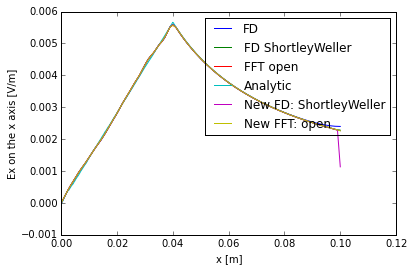

In [7]:
plt.close('all')
plt.plot(x_probes, Ex_FD, label = 'FD')
plt.plot(x_probes, Ex_FDSW, label = 'FD ShortleyWeller')
plt.plot(x_probes, Ex_FFT, label = 'FFT open')
plt.plot(x_probes, E_r_th, label = 'Analytic')
plt.plot(x_probes, Ex, label = 'New FD: ShortleyWeller')
plt.plot(x_probes, Ex_FFT, label = 'New FFT: open')

#pl.plot(picFFT.xg, picFFT.efx[picFFT.ny/2, :])
plt.legend()
plt.ylabel('Ex on the x axis [V/m]')
plt.xlabel('x [m]')

plt.show()